In [1]:
# Load the learner framework for PyTorch
# Refers to https://github.com/fastai/course22p2/blob/master/nbs/09_learner.ipynb

import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision , torcheval
import random,math
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import fastcore.all as fc
import torch.optim as optim
from operator import attrgetter
from functools import partial
from datasets import load_dataset,load_dataset_builder
from torch.utils.data import DataLoader,default_collate,Dataset
from torcheval.metrics import MulticlassAccuracy,Mean
from copy import copy
from torch.optim.lr_scheduler import ExponentialLR
from collections.abc import Mapping
from fastprogress import progress_bar,master_bar
from torch.optim.lr_scheduler import ExponentialLR
%matplotlib inline

def_device = 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

class Dataloaders():
    def __init__(self,train_dl,valid_dl): self.train,self.valid = train_dl,valid_dl


class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def run_cbs(self,cbs, method_nm, learn=None):
        for cb in sorted(cbs, key=attrgetter('order')):
            method = getattr(cb, method_nm, None)
            if method is not None: method(learn)

    def callback(self, method_nm): self.run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

class Callback(): order = 0

class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
    
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))
    
class BaseSchedCB(Callback):
    def __init__(self, sched):
        self.sched = sched
    def before_fit(self, learn): self.sched = self.sched(learn.opt)
    def _step(self,learn): 
        if learn.training: self.sched.step()
    
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
import logging
logging.disable(logging.WARNING)

In [2]:
# Load the datasets

batch_size = 256

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = T.ToTensor())
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = T.ToTensor())

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

dls = Dataloaders(train_dl,valid_dl)

## Autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,200),
                                    nn.BatchNorm1d(200),
                                    nn.SiLU())
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [4]:
class ChangeLabels(Callback):
    order = DeviceCB.order+20
    def before_batch(self, learn):
        learn.batch = (learn.batch[0],learn.batch[0])

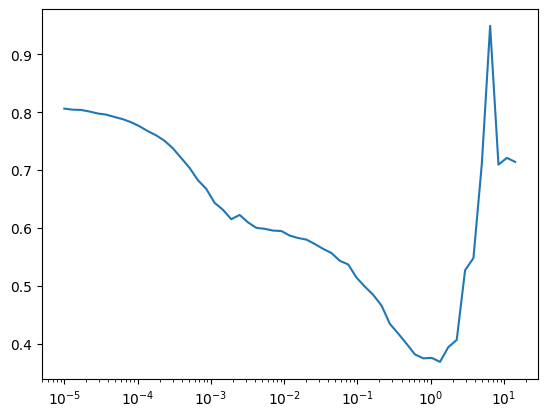

In [5]:
opt = partial(optim.Adam, eps = 1e-5)
Learner(AutoEncoder(),dls,loss_func=nn.BCEWithLogitsLoss(),lr=0.1,cbs=[DeviceCB(),ChangeLabels(),MixedPrecision()],opt_func=opt).lr_find()

In [6]:
model = AutoEncoder()

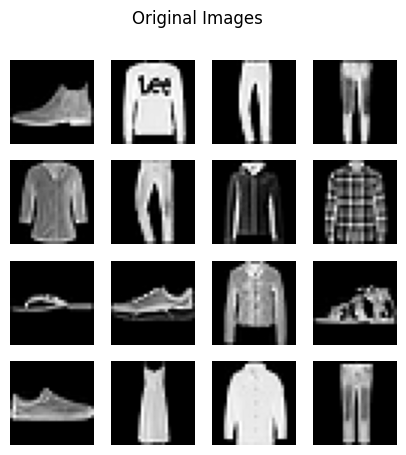

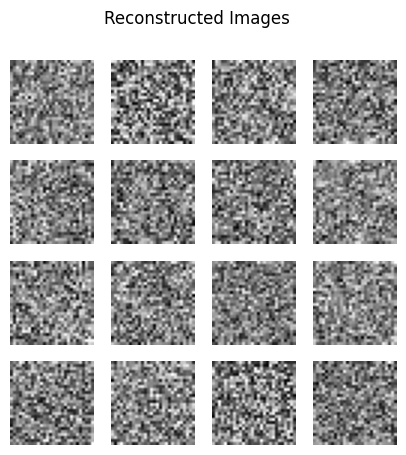

In [7]:
batch = next(iter(valid_dl))
preds = model(batch[0]).detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [8]:
epochs = 20
lr = 3e-2
opt = partial(optim.Adam, eps = 1e-5)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, steps_per_epoch=len(train_dl), epochs=epochs)
cbs = [DeviceCB(),ChangeLabels(),MixedPrecision(),ProgressCB(plot = True), MetricsCB(),BatchSchedCB(sched)]
learn = Learner(model,dls,loss_func=nn.BCEWithLogitsLoss(),lr=lr,cbs=cbs,opt_func=opt)
# learn.fit(epochs)

In [9]:
# model = learn.model.cpu()
# torch.save(model,'autoencoder.pth')

In [10]:
model = torch.load('autoencoder.pth')

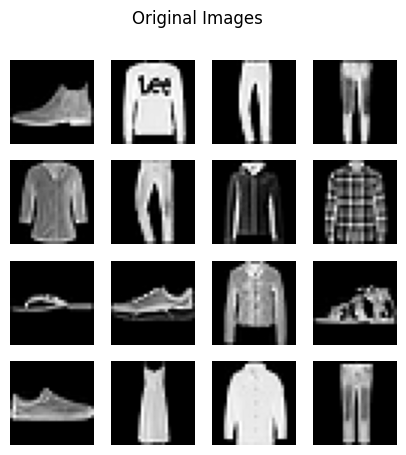

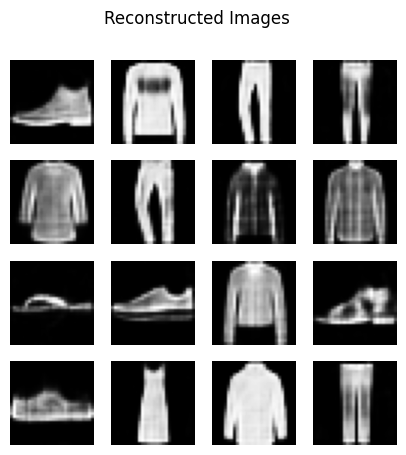

In [11]:
batch = next(iter(valid_dl))
preds = model(batch[0]).detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

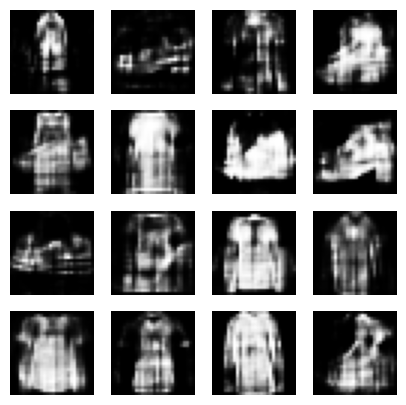

In [12]:
random_noise = torch.randn(16,1,28,28)
preds = model(random_noise).detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

## VAE

In [13]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU())
        
        self.mu = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))

        self.logvar = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return self.decoder(z),mu,logvar

In [14]:
def KLDivergence_loss(input, target):
    _ , mu, logvar = input
    KLD = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    return KLD

def BCE_loss(input, target):
    BCE = F.binary_cross_entropy_with_logits(input[0], target)
    return BCE

def vae_loss_func(input, target):
    BCE = BCE_loss(input, target)
    KLD = KLDivergence_loss(input, target)
    return BCE + KLD

In [15]:
class FuncMetric(Mean):
    def __init__(self, fn, device=None):
        super().__init__(device=device)
        self.fn = fn

    def update(self, inp, targets): 
        self.weighted_sum += self.fn(inp, targets)
        self.weights += 1

In [16]:
model = VAE()

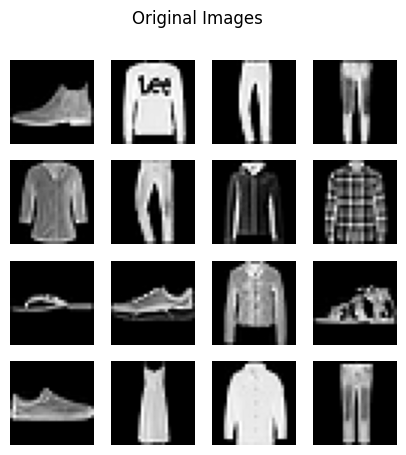

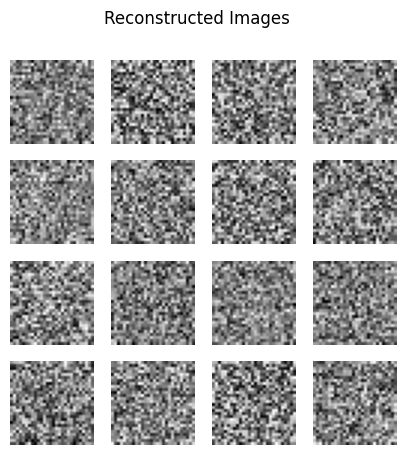

In [17]:
batch = next(iter(valid_dl))
preds = model(batch[0])[0].detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [18]:
lr = 3e-2
epochs = 20
tmax = epochs * len(dls.train)
opt = partial(optim.Adam, eps=1e-5)
sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
metrics = MetricsCB(kld=FuncMetric(KLDivergence_loss), bce=FuncMetric(BCE_loss))
cbs = [DeviceCB(), ProgressCB(plot=True), metrics, BatchSchedCB(sched), MixedPrecision(), ChangeLabels()]
learn = Learner(model, dls, vae_loss_func, lr=lr, cbs=cbs, opt_func=opt)
# learn.fit(epochs)

In [19]:
# model = learn.model.cpu()
# torch.save(model,'VAE.pth')

In [20]:
model = torch.load('VAE.pth')

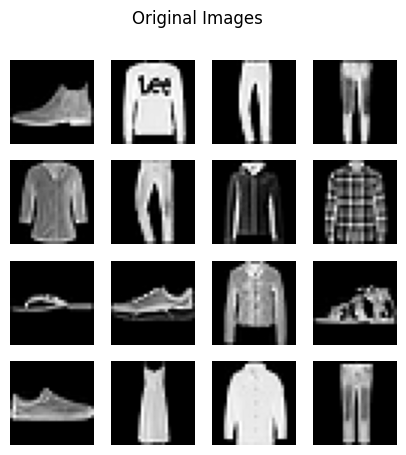

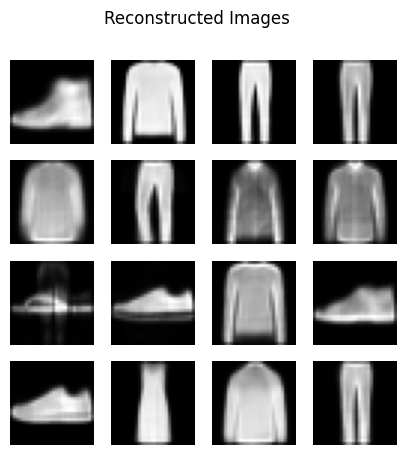

In [21]:
batch = next(iter(valid_dl))
preds = model(batch[0])[0].detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

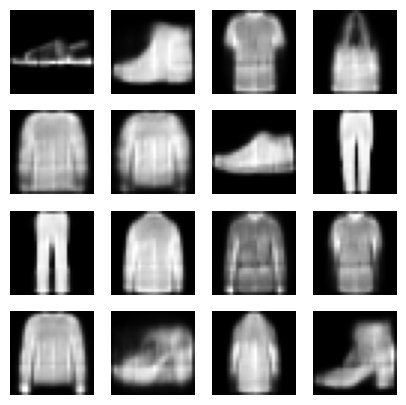

In [22]:
random_noise = torch.randn(16,1,28,28)
preds = model(random_noise)[0].detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')